In [1]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Importing the Data                                                                       Shape

Endg_Truth = loadmat('end6_groundTruth.mat')      
Ground_Truth = loadmat('groundTruth.mat')               
Urban = loadmat('Urban_R162.mat')                 
image = Urban['Y'].T                                                                #    94249*162  
groundTruth = Ground_Truth ['groundTruth']                                          #     307*307
image_shape = (Ground_Truth ['nRow'], Ground_Truth ['nCol'], image.shape[1])


def hyper_to_2D(img):
    """
    
    Converts a 3D HSI cube (m x n x p) to a 2D matrix of points (N X p)
+   N = m*n, p := number of bands

    """
    img = np.array(img)
    ndim = img.ndim

    if ndim not in [2, 3]:
      raise "invalid dimention. ndim = 2 or 3"

    if ndim == 2:
      m, n = np.shape(img)
      
      hyper_img = np.empty((m,n,1))
      hyper_img[:,:,0] = img

      return hyper_to_2D(hyper_img).ravel()

    m, n, p = np.shape(img)
    N = n * m
    
    dataset = img.T.reshape((p, N)).T

    if p == 1:
      return dataset.ravel()
    
    return dataset

image = image
groundTruth = hyper_to_2D(groundTruth)

print(image.shape)
print(groundTruth.shape)


(94249, 162)
(94249,)


In [3]:
# Standardization
# Split into train (2/3) and test (1/3) sets

image = StandardScaler().fit_transform(image)
seed = 40
X_train, X_test, y_train, y_test = train_test_split(image, groundTruth, test_size = 0.30 , train_size = 0.70 , random_state = seed , stratify=groundTruth)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(65974, 162)
(28275, 162)
(65974,)
(28275,)


In [4]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs = SFS (clf,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 20.3min finished

[2022-02-07 10:17:58] Features: 1/5 -- score: 0.6059205353771849[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed: 39.7min finished

[2022-02-07 10:57:38] Features: 2/5 -- score: 0.759556866794953[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 35.2min finished

[2022-02-07 11:32:52] Features: 3/5 -- score: 0.901991708771593[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 ou

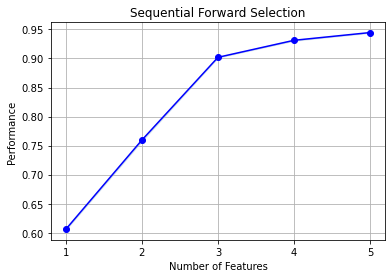

In [5]:
# Perform SFFS

sfs = sfs.fit(X_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [6]:
# Which features?

SFS_FS = list(sfs.k_feature_idx_)
print(SFS_FS)


[14, 48, 76, 107, 129]


In [7]:
# Build full model with selected features

Model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
Model.fit(X_train[:, SFS_FS], y_train)
predict = Model.predict(X_test[:, SFS_FS])
acc_train = Model.score(X_train[:, SFS_FS], y_train)
acc_test = Model.score(X_test[:, SFS_FS], y_test)
print( acc_train , acc_test)


1.0 0.9470557029177719
